In [264]:
import os.path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error as mse_sklearn
from sklearn.metrics import mean_absolute_error as mae_sklearn

In [265]:
use_GPU = torch.cuda.is_available()
if use_GPU:
    mode = {"name": "cuda", "device": torch.device("cuda")}
else:
    mode = {"name": "cpu", "device": torch.device("cpu")}

in_dim = 1
hidden_dim = 64
out_dim = 1
sequence_length = 72
batch_size = 128 # 32, 64, 128, 256

num_epochs=30
num_workers=11
lr = 1e-3
regularization=1e-6

In [266]:
def get_data(path):
    data = []
    for i in ["/train", "/val", "/test"]:
        data.append(pd.read_csv(path + i + ".csv", index_col="Datetime"))
    return data[0], data[1], data[2]
# Load data
path = '../data/clean_data/univariate_Q_Kalltveit'
train, val, test = get_data(path)
train

,Q_Kalltveit
Datetime,
2015-01-01 00:00:00,3.37060
2015-01-01 01:00:00,3.45242
2015-01-01 02:00:00,3.56260
2015-01-01 03:00:00,3.74423
2015-01-01 04:00:00,4.02901
...,...
2020-01-20 16:00:00,7.14669
2020-01-20 17:00:00,7.45883
2020-01-20 18:00:00,7.81983


In [267]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

In [268]:
X_train, y_train = sliding_windows(train.values, sequence_length)
X_val, y_val = sliding_windows(val.values, sequence_length)
X_test, y_test = sliding_windows(test.values, sequence_length)

X_train, X_val, X_test = X_train.reshape(len(X_train), -1), X_val.reshape(len(X_val), -1), X_test.reshape(len(X_test), -1)
print(X_train.shape, X_val.shape, X_test.shape)

(44288, 12) (13277, 12) (5684, 12)


In [269]:
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0,0,0),std=(1,1,1))])

In [270]:
from torch.utils.data import Dataset
import torch

class data_trans(Dataset):
        
    def __init__(self, data, groundtruth, transform=None):

        self.data = self._get_data(data)
        self.groundtruth = self._get_data(groundtruth)
        self.transform = transform

    def _get_data(self,data):
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self,index):
               
        inputs = self.data[index,:]
        groundtruths = self.groundtruth[index,:]
        
        if self.transform:
                        
            inputs = torch.from_numpy(inputs).float()
            groundtruths = torch.from_numpy(groundtruths).float()
                       
        return [inputs, groundtruths]

In [271]:
train_data_trans = data_trans(X_train, y_train, transform)
val_data_trans = data_trans(X_val, y_val, transform)
test_data_trans = data_trans(X_test, y_test, transform)

In [272]:
train_dataloader = torch.utils.data.DataLoader(train_data_trans,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 0)
val_dataloader = torch.utils.data.DataLoader(val_data_trans,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 0)
test_dataloader = torch.utils.data.DataLoader(test_data_trans,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           num_workers = 0)

In [273]:
data_loader = {
    "train": train_dataloader,
    "val": val_dataloader,
    "test": test_dataloader,
}

In [274]:
class FCN(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):

        super(FCN, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length

        self.layer_in = nn.Linear(sequence_length, hidden_dim, bias=False)
        self.fcn = nn.Linear(hidden_dim, hidden_dim)
        self.layer_out = nn.Linear(hidden_dim, out_dim, bias=False)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward (self,input):
        out = self.layer_in(input)
        out = self.sigmoid(out)
        out = self.fcn(out)
        out = self.sigmoid(out)
        out = self.layer_out(out)
      
        return out

In [275]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):
        super(LSTM, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length
        
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(in_dim, hidden_dim)
        self.lstm2 = nn.LSTMCell(hidden_dim, hidden_dim)
        
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim*sequence_length, out_dim)

        
    def forward(self, y):
        outputs = []
        h_t = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        c_t = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        h_t2 = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        c_t2 = torch.zeros(y.size(0), self.hidden_dim, dtype=torch.float32).to(mode["device"])
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        out = self.linear_out(outputs)
        return out

In [276]:
class LSTM2(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, sequence_length):
        super(LSTM2, self).__init__()
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.sequence_length = sequence_length

        self.lstm1 = nn.LSTMCell(in_dim, hidden_dim)
        self.lstm2 = nn.LSTMCell(hidden_dim, hidden_dim)

        self.T_A = nn.Linear(sequence_length*hidden_dim, sequence_length)
        
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.linear_out = nn.Linear(hidden_dim, out_dim)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, y):
        outputs = []
        h_t = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        c_t = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        h_t2 = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        c_t2 = torch.zeros(y.size(0), self.hidden_dim).to(mode["device"])
        
        for time_step in y.split(1, dim=1):
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        total_ht = outputs[0]
        for i in range(1, len(outputs)):
            total_ht = torch.cat((total_ht, outputs[i]), 1)

        beta_t =  self.relu(self.T_A(total_ht))
        beta_t = self.softmax(beta_t)

        out = torch.zeros(y.size(0), self.hidden_dim)

        for i in range(len(outputs)):
                      
            out = out + outputs[i]*beta_t[:,i].reshape(out.size(0), 1)

        out = self.linear_out(out)
        
        return out

In [277]:
from tqdm import tqdm
from torchmetrics.functional import mean_absolute_error

def fit(model, loss_function, optimizer, data_loader, num_epochs, mode, use_amp=False):
	history = {"train": {"loss": [], "mae": []}, "val": {"loss": [], "mae": []}}
	scaler = torch.cuda.amp.GradScaler(enabled=use_amp) # Mixed-precision support for compatible GPUs
	print("\nTraining the model:")
	for epoch in range(num_epochs):
		
		print("\nEpoch", epoch+1)
		if epoch < num_epochs - 1:
			keys = ["train", "val"]
		else:
			keys = ["train", "val", "test"]
		for key in keys:
			dataset_size = 0
			dataset_loss = 0.0
			#dataset_mae = []
			if key == "train":
				model.train()
			else:
				model.eval()
			for X_batch, y_batch in tqdm(data_loader[key]):
				X_batch, y_batch = X_batch.to(mode["device"]), y_batch.to(mode["device"])
				with torch.set_grad_enabled(mode=(key=="train")): # Autograd activated only during training
					with torch.cuda.amp.autocast(enabled=use_amp): # Mixed-precision support for compatible GPUs
						batch_output = model(X_batch.float())
						batch_loss = loss_function(batch_output, y_batch)
					if key == "train":
						scaler.scale(batch_loss).backward()
						scaler.step(optimizer) 	
						scaler.update()
						optimizer.zero_grad()
				dataset_size += y_batch.shape[0]
				dataset_loss += y_batch.shape[0] * batch_loss.item()
				#dataset_mae += mean_absolute_error(batch_output, y_batch).item()
			dataset_loss /= dataset_size
			#dataset_mae /= dataset_size
			if key in ["train", "val"]:
				history[key]["loss"].append(dataset_loss)
				#history[key]["mae"].append(dataset_mae)
			else:
				print("\nEvaluating the model:")
			print(key, "loss:", dataset_loss, "    ", 
					#key, "mae:", dataset_mae
					)
	return history


In [278]:
model_1 = FCN(in_dim, hidden_dim, out_dim, sequence_length).to(mode["device"])
optimizer = optimizer = optim.Adam(model_1.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])

history = fit(model=model_1, loss_function=error_criterion, optimizer=optimizer, data_loader=data_loader, num_epochs=num_epochs, mode=mode)



Training the model:

Epoch 1


100%|██████████| 346/346 [00:01<00:00, 300.43it/s]


train loss: 65.10295168335168     


100%|██████████| 104/104 [00:00<00:00, 634.36it/s]


val loss: 53.296338900426534     

Epoch 2


100%|██████████| 346/346 [00:01<00:00, 338.40it/s]


train loss: 56.993688495431336     


100%|██████████| 104/104 [00:00<00:00, 627.61it/s]


val loss: 51.03501518930739     

Epoch 3


100%|██████████| 346/346 [00:01<00:00, 332.30it/s]


train loss: 54.45457589833033     


100%|██████████| 104/104 [00:00<00:00, 604.59it/s]


val loss: 47.458053325398225     

Epoch 4


100%|██████████| 346/346 [00:01<00:00, 328.05it/s]


train loss: 49.34461294268554     


100%|██████████| 104/104 [00:00<00:00, 618.19it/s]


val loss: 40.238821064751576     

Epoch 5


100%|██████████| 346/346 [00:01<00:00, 331.99it/s]


train loss: 41.71727044424957     


100%|██████████| 104/104 [00:00<00:00, 619.01it/s]


val loss: 30.461565169129305     

Epoch 6


100%|██████████| 346/346 [00:01<00:00, 308.99it/s]


train loss: 33.033209793417676     


100%|██████████| 104/104 [00:00<00:00, 682.59it/s]


val loss: 23.07481772806519     

Epoch 7


100%|██████████| 346/346 [00:00<00:00, 375.33it/s]


train loss: 27.48814644538976     


100%|██████████| 104/104 [00:00<00:00, 703.22it/s]


val loss: 18.17492867663358     

Epoch 8


100%|██████████| 346/346 [00:01<00:00, 332.39it/s]


train loss: 23.870423052118113     


100%|██████████| 104/104 [00:00<00:00, 600.16it/s]


val loss: 14.313665929644987     

Epoch 9


100%|██████████| 346/346 [00:00<00:00, 351.48it/s]


train loss: 21.06554008033692     


100%|██████████| 104/104 [00:00<00:00, 663.16it/s]


val loss: 11.52647823550426     

Epoch 10


100%|██████████| 346/346 [00:01<00:00, 321.19it/s]


train loss: 18.610794353258004     


100%|██████████| 104/104 [00:00<00:00, 634.42it/s]


val loss: 9.300525350419434     

Epoch 11


100%|██████████| 346/346 [00:00<00:00, 354.83it/s]


train loss: 16.76063954912308     


100%|██████████| 104/104 [00:00<00:00, 664.17it/s]


val loss: 8.0831043444029     

Epoch 12


100%|██████████| 346/346 [00:00<00:00, 354.29it/s]


train loss: 15.366755037257787     


100%|██████████| 104/104 [00:00<00:00, 671.44it/s]


val loss: 7.041990159163186     

Epoch 13


100%|██████████| 346/346 [00:01<00:00, 330.75it/s]


train loss: 14.13108415570651     


100%|██████████| 104/104 [00:00<00:00, 727.94it/s]


val loss: 6.223184173462207     

Epoch 14


100%|██████████| 346/346 [00:00<00:00, 401.35it/s]


train loss: 13.361928251757174     


100%|██████████| 104/104 [00:00<00:00, 717.41it/s]


val loss: 4.658769369549606     

Epoch 15


100%|██████████| 346/346 [00:00<00:00, 366.46it/s]


train loss: 14.013187196567342     


100%|██████████| 104/104 [00:00<00:00, 645.48it/s]


val loss: 4.561175538412848     

Epoch 16


100%|██████████| 346/346 [00:01<00:00, 342.59it/s]


train loss: 11.18278528909139     


100%|██████████| 104/104 [00:00<00:00, 625.51it/s]


val loss: 3.2488135472198176     

Epoch 17


100%|██████████| 346/346 [00:01<00:00, 331.89it/s]


train loss: 13.603395975820183     


100%|██████████| 104/104 [00:00<00:00, 545.34it/s]


val loss: 3.8178564600375453     

Epoch 18


100%|██████████| 346/346 [00:00<00:00, 348.18it/s]


train loss: 9.908830421866385     


100%|██████████| 104/104 [00:00<00:00, 616.15it/s]


val loss: 3.1056188700733713     

Epoch 19


100%|██████████| 346/346 [00:01<00:00, 332.65it/s]


train loss: 9.962577046622586     


100%|██████████| 104/104 [00:00<00:00, 653.87it/s]


val loss: 2.61004691737607     

Epoch 20


100%|██████████| 346/346 [00:00<00:00, 353.68it/s]


train loss: 10.562093382703969     


100%|██████████| 104/104 [00:00<00:00, 642.94it/s]


val loss: 3.2102208264447607     

Epoch 21


100%|██████████| 346/346 [00:01<00:00, 326.32it/s]


train loss: 8.643930530224269     


100%|██████████| 104/104 [00:00<00:00, 643.60it/s]


val loss: 2.2231246679056085     

Epoch 22


100%|██████████| 346/346 [00:00<00:00, 366.23it/s]


train loss: 9.269122062505756     


100%|██████████| 104/104 [00:00<00:00, 671.38it/s]


val loss: 2.754713751853226     

Epoch 23


100%|██████████| 346/346 [00:00<00:00, 356.63it/s]


train loss: 8.218384760319568     


100%|██████████| 104/104 [00:00<00:00, 640.91it/s]


val loss: 2.639851563714162     

Epoch 24


100%|██████████| 346/346 [00:01<00:00, 344.79it/s]


train loss: 8.072764410026307     


100%|██████████| 104/104 [00:00<00:00, 641.09it/s]


val loss: 2.6961011631603546     

Epoch 25


100%|██████████| 346/346 [00:01<00:00, 337.59it/s]


train loss: 7.695514399662945     


100%|██████████| 104/104 [00:00<00:00, 645.06it/s]


val loss: 2.702671225635081     

Epoch 26


100%|██████████| 346/346 [00:00<00:00, 352.57it/s]


train loss: 7.513804158992928     


100%|██████████| 104/104 [00:00<00:00, 648.86it/s]


val loss: 2.7380267258167015     

Epoch 27


100%|██████████| 346/346 [00:01<00:00, 329.69it/s]


train loss: 7.126453142404904     


100%|██████████| 104/104 [00:00<00:00, 646.96it/s]


val loss: 2.5831232254569536     

Epoch 28


100%|██████████| 346/346 [00:00<00:00, 353.03it/s]


train loss: 7.226272526736818     


100%|██████████| 104/104 [00:00<00:00, 638.14it/s]


val loss: 2.484959844536583     

Epoch 29


100%|██████████| 346/346 [00:01<00:00, 340.98it/s]


train loss: 6.387564499229273     


100%|██████████| 104/104 [00:00<00:00, 633.94it/s]


val loss: 2.4589131467154903     

Epoch 30


100%|██████████| 346/346 [00:01<00:00, 336.49it/s]


train loss: 7.818307208685632     


100%|██████████| 104/104 [00:00<00:00, 651.27it/s]


val loss: 2.3821559111949164     


100%|██████████| 45/45 [00:00<00:00, 646.55it/s]


Evaluating the model:
test loss: 4.305660300821926     


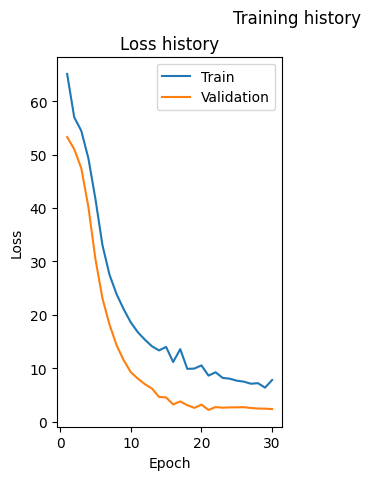

In [279]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()
print_history(history)

In [280]:
model_2 = LSTM(in_dim, hidden_dim, out_dim, sequence_length)
model_2.to(mode["device"])
optimizer = optimizer = optim.Adam(model_2.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])
history = fit(model=model_2, 
            loss_function=error_criterion, 
            optimizer=optimizer, 
            data_loader=data_loader, 
            num_epochs=num_epochs, 
            mode=mode
            )



Training the model:

Epoch 1


100%|██████████| 346/346 [00:04<00:00, 76.06it/s]


train loss: 27.302220912286263     


100%|██████████| 104/104 [00:00<00:00, 261.15it/s]


val loss: 4.640329101639959     

Epoch 2


100%|██████████| 346/346 [00:04<00:00, 76.75it/s]


train loss: 6.116471593781318     


100%|██████████| 104/104 [00:00<00:00, 241.08it/s]


val loss: 1.5236982274720574     

Epoch 3


100%|██████████| 346/346 [00:04<00:00, 78.17it/s]


train loss: 2.051994363860445     


100%|██████████| 104/104 [00:00<00:00, 263.90it/s]


val loss: 0.7721509502163478     

Epoch 4


100%|██████████| 346/346 [00:04<00:00, 78.59it/s]


train loss: 1.3110614746851568     


100%|██████████| 104/104 [00:00<00:00, 261.84it/s]


val loss: 0.4114025127226281     

Epoch 5


100%|██████████| 346/346 [00:04<00:00, 78.78it/s]


train loss: 1.8368980417269816     


100%|██████████| 104/104 [00:00<00:00, 268.03it/s]


val loss: 0.43334276505628877     

Epoch 6


100%|██████████| 346/346 [00:04<00:00, 78.18it/s]


train loss: 0.6976335814562392     


100%|██████████| 104/104 [00:00<00:00, 272.72it/s]


val loss: 0.21488716497729995     

Epoch 7


100%|██████████| 346/346 [00:04<00:00, 77.65it/s]


train loss: 0.4982899263013468     


100%|██████████| 104/104 [00:00<00:00, 266.87it/s]


val loss: 0.13444929487959484     

Epoch 8


100%|██████████| 346/346 [00:04<00:00, 79.17it/s]


train loss: 0.8976028806368774     


100%|██████████| 104/104 [00:00<00:00, 274.31it/s]


val loss: 0.18392691166533165     

Epoch 9


100%|██████████| 346/346 [00:04<00:00, 79.31it/s]


train loss: 0.375250749062416     


100%|██████████| 104/104 [00:00<00:00, 270.53it/s]


val loss: 0.0990108432232943     

Epoch 10


100%|██████████| 346/346 [00:04<00:00, 78.17it/s]


train loss: 1.7174665125776563     


100%|██████████| 104/104 [00:00<00:00, 267.56it/s]


val loss: 0.2605399450738539     

Epoch 11


100%|██████████| 346/346 [00:04<00:00, 77.12it/s]


train loss: 1.6397839175000406     


100%|██████████| 104/104 [00:00<00:00, 269.49it/s]


val loss: 0.19067160827117197     

Epoch 12


100%|██████████| 346/346 [00:04<00:00, 79.56it/s]


train loss: 0.33435567481997774     


100%|██████████| 104/104 [00:00<00:00, 272.86it/s]


val loss: 0.09660125233192571     

Epoch 13


100%|██████████| 346/346 [00:04<00:00, 79.81it/s]


train loss: 0.20719863678829767     


100%|██████████| 104/104 [00:00<00:00, 266.59it/s]


val loss: 0.0834066310621517     

Epoch 14


100%|██████████| 346/346 [00:04<00:00, 77.48it/s]


train loss: 0.2159819706499821     


100%|██████████| 104/104 [00:00<00:00, 272.95it/s]


val loss: 0.07982133645730563     

Epoch 15


100%|██████████| 346/346 [00:04<00:00, 77.75it/s]


train loss: 0.5394871747735887     


100%|██████████| 104/104 [00:00<00:00, 274.22it/s]


val loss: 0.15066336856201967     

Epoch 16


100%|██████████| 346/346 [00:04<00:00, 79.46it/s]


train loss: 0.41997915532009616     


100%|██████████| 104/104 [00:00<00:00, 272.52it/s]


val loss: 0.07969914386805083     

Epoch 17


100%|██████████| 346/346 [00:04<00:00, 79.07it/s]


train loss: 0.1539860272661164     


100%|██████████| 104/104 [00:00<00:00, 272.80it/s]


val loss: 0.07640114037066512     

Epoch 18


100%|██████████| 346/346 [00:04<00:00, 77.02it/s]


train loss: 1.6285571818013045     


100%|██████████| 104/104 [00:00<00:00, 267.52it/s]


val loss: 4.071465525487429     

Epoch 19


100%|██████████| 346/346 [00:04<00:00, 78.78it/s]


train loss: 3.679824397382407     


100%|██████████| 104/104 [00:00<00:00, 261.27it/s]


val loss: 0.2730971603621567     

Epoch 20


100%|██████████| 346/346 [00:04<00:00, 79.12it/s]


train loss: 0.5864422297361912     


100%|██████████| 104/104 [00:00<00:00, 267.63it/s]


val loss: 0.12330089464169615     

Epoch 21


100%|██████████| 346/346 [00:04<00:00, 79.11it/s]


train loss: 0.28094935311268054     


100%|██████████| 104/104 [00:00<00:00, 266.19it/s]


val loss: 0.10010900779588613     

Epoch 22


100%|██████████| 346/346 [00:04<00:00, 76.83it/s]


train loss: 0.23909553220279658     


100%|██████████| 104/104 [00:00<00:00, 269.77it/s]


val loss: 0.0908056820815106     

Epoch 23


100%|██████████| 346/346 [00:04<00:00, 77.99it/s]


train loss: 0.22436997705282047     


100%|██████████| 104/104 [00:00<00:00, 264.23it/s]


val loss: 0.09063164982983307     

Epoch 24


100%|██████████| 346/346 [00:04<00:00, 78.85it/s]


train loss: 0.2054983525322629     


100%|██████████| 104/104 [00:00<00:00, 271.63it/s]


val loss: 0.11091892625141175     

Epoch 25


100%|██████████| 346/346 [00:04<00:00, 79.01it/s]


train loss: 0.5760262022419049     


100%|██████████| 104/104 [00:00<00:00, 258.86it/s]


val loss: 0.08308253909107736     

Epoch 26


100%|██████████| 346/346 [00:04<00:00, 78.28it/s]


train loss: 0.19934089576893296     


100%|██████████| 104/104 [00:00<00:00, 274.01it/s]


val loss: 0.08720082441712981     

Epoch 27


100%|██████████| 346/346 [00:04<00:00, 78.78it/s]


train loss: 0.1235578583443537     


100%|██████████| 104/104 [00:00<00:00, 269.48it/s]


val loss: 0.06979024570442721     

Epoch 28


100%|██████████| 346/346 [00:04<00:00, 79.23it/s]


train loss: 1.9374127720143748     


100%|██████████| 104/104 [00:00<00:00, 267.93it/s]


val loss: 0.32797013724375274     

Epoch 29


100%|██████████| 346/346 [00:04<00:00, 77.94it/s]


train loss: 0.47585786741904545     


100%|██████████| 104/104 [00:00<00:00, 263.63it/s]


val loss: 0.08325397201629345     

Epoch 30


100%|██████████| 346/346 [00:04<00:00, 77.61it/s]


train loss: 0.21053054361334816     


100%|██████████| 104/104 [00:00<00:00, 270.70it/s]


val loss: 0.07243472287158353     


100%|██████████| 45/45 [00:00<00:00, 263.94it/s]


Evaluating the model:
test loss: 0.08963805577081328     


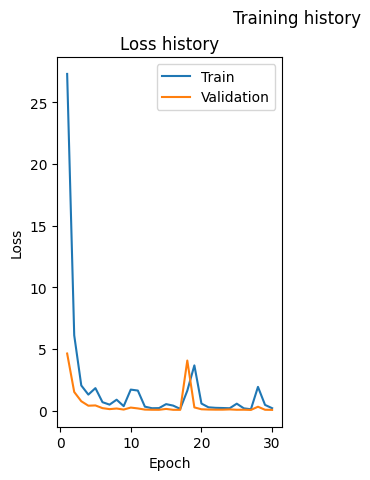

In [281]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()
print_history(history)

In [282]:
model_3 = LSTM(in_dim, hidden_dim, out_dim, sequence_length).to(mode["device"])
optimizer = optimizer = optim.Adam(model_3.parameters(), lr=lr, weight_decay=regularization)
error_criterion = nn.MSELoss().to(mode["device"])
history = fit(model=model_3, loss_function=error_criterion, optimizer=optimizer, data_loader=data_loader, num_epochs=num_epochs, mode=mode)



Training the model:

Epoch 1


100%|██████████| 346/346 [00:04<00:00, 76.26it/s]


train loss: 28.212299496876184     


100%|██████████| 104/104 [00:00<00:00, 260.38it/s]


val loss: 3.9285250359625263     

Epoch 2


100%|██████████| 346/346 [00:04<00:00, 77.51it/s]


train loss: 5.959911517964103     


100%|██████████| 104/104 [00:00<00:00, 261.97it/s]


val loss: 1.7389006349394558     

Epoch 3


100%|██████████| 346/346 [00:04<00:00, 78.51it/s]


train loss: 3.136978283327179     


100%|██████████| 104/104 [00:00<00:00, 268.86it/s]


val loss: 0.6114960109331418     

Epoch 4


100%|██████████| 346/346 [00:04<00:00, 79.32it/s]


train loss: 1.0693162612500853     


100%|██████████| 104/104 [00:00<00:00, 271.06it/s]


val loss: 0.5497421906334953     

Epoch 5


100%|██████████| 346/346 [00:04<00:00, 78.50it/s]


train loss: 1.5484288804810271     


100%|██████████| 104/104 [00:00<00:00, 272.32it/s]


val loss: 0.33118178440391044     

Epoch 6


100%|██████████| 346/346 [00:04<00:00, 79.05it/s]


train loss: 0.6461764269851947     


100%|██████████| 104/104 [00:00<00:00, 274.50it/s]


val loss: 0.21886420150051691     

Epoch 7


100%|██████████| 346/346 [00:04<00:00, 75.60it/s]


train loss: 0.6266248092013936     


100%|██████████| 104/104 [00:00<00:00, 236.01it/s]


val loss: 0.15339494779130247     

Epoch 8


100%|██████████| 346/346 [00:04<00:00, 77.08it/s]


train loss: 0.687641534883821     


100%|██████████| 104/104 [00:00<00:00, 266.29it/s]


val loss: 0.10266020477112416     

Epoch 9


100%|██████████| 346/346 [00:04<00:00, 74.68it/s]


train loss: 0.5091344917247226     


100%|██████████| 104/104 [00:00<00:00, 259.07it/s]


val loss: 0.09487330622860508     

Epoch 10


100%|██████████| 346/346 [00:04<00:00, 72.43it/s]


train loss: 1.6905430120672453     


100%|██████████| 104/104 [00:00<00:00, 263.96it/s]


val loss: 0.17427827286979927     

Epoch 11


100%|██████████| 346/346 [00:04<00:00, 77.21it/s]


train loss: 0.5404831887685208     


100%|██████████| 104/104 [00:00<00:00, 263.81it/s]


val loss: 0.09525877179870734     

Epoch 12


100%|██████████| 346/346 [00:04<00:00, 76.82it/s]


train loss: 0.2492675647591079     


100%|██████████| 104/104 [00:00<00:00, 265.99it/s]


val loss: 0.09019342610681114     

Epoch 13


100%|██████████| 346/346 [00:04<00:00, 77.60it/s]


train loss: 0.8266282253910456     


100%|██████████| 104/104 [00:00<00:00, 271.80it/s]


val loss: 0.10999101432347712     

Epoch 14


100%|██████████| 346/346 [00:04<00:00, 77.88it/s]


train loss: 0.5518301794021724     


100%|██████████| 104/104 [00:00<00:00, 272.13it/s]


val loss: 0.09001529283404637     

Epoch 15


100%|██████████| 346/346 [00:04<00:00, 79.43it/s]


train loss: 0.23301859609443712     


100%|██████████| 104/104 [00:00<00:00, 274.33it/s]


val loss: 0.08065928791578722     

Epoch 16


100%|██████████| 346/346 [00:04<00:00, 79.16it/s]


train loss: 1.035034910237994     


100%|██████████| 104/104 [00:00<00:00, 264.81it/s]


val loss: 0.11692501657152177     

Epoch 17


100%|██████████| 346/346 [00:04<00:00, 77.06it/s]


train loss: 0.32420417064323465     


100%|██████████| 104/104 [00:00<00:00, 259.30it/s]


val loss: 0.0911740709573604     

Epoch 18


100%|██████████| 346/346 [00:04<00:00, 78.19it/s]


train loss: 0.208865004125604     


100%|██████████| 104/104 [00:00<00:00, 262.58it/s]


val loss: 0.08497012120277983     

Epoch 19


100%|██████████| 346/346 [00:04<00:00, 79.47it/s]


train loss: 0.6794353114710248     


100%|██████████| 104/104 [00:00<00:00, 270.21it/s]


val loss: 0.10277013865334525     

Epoch 20


100%|██████████| 346/346 [00:04<00:00, 79.05it/s]


train loss: 2.1162910004225846     


100%|██████████| 104/104 [00:00<00:00, 273.06it/s]


val loss: 0.2951288521171981     

Epoch 21


100%|██████████| 346/346 [00:04<00:00, 77.88it/s]


train loss: 0.39397843059602716     


100%|██████████| 104/104 [00:00<00:00, 267.22it/s]


val loss: 0.08702292228927065     

Epoch 22


100%|██████████| 346/346 [00:04<00:00, 74.19it/s]


train loss: 0.23612756888695718     


100%|██████████| 104/104 [00:00<00:00, 234.30it/s]


val loss: 0.0792569963339978     

Epoch 23


100%|██████████| 346/346 [00:04<00:00, 73.71it/s]


train loss: 0.22051290545755234     


100%|██████████| 104/104 [00:00<00:00, 267.32it/s]


val loss: 0.0775135764232781     

Epoch 24


100%|██████████| 346/346 [00:04<00:00, 74.96it/s]


train loss: 0.2438145042917544     


100%|██████████| 104/104 [00:00<00:00, 259.88it/s]


val loss: 0.07121600636734284     

Epoch 25


100%|██████████| 346/346 [00:04<00:00, 75.50it/s]


train loss: 0.464692464338483     


100%|██████████| 104/104 [00:00<00:00, 267.07it/s]


val loss: 0.08560106746237642     

Epoch 26


100%|██████████| 346/346 [00:04<00:00, 78.39it/s]


train loss: 0.6008770696661869     


100%|██████████| 104/104 [00:00<00:00, 264.51it/s]


val loss: 0.08367852025692069     

Epoch 27


100%|██████████| 346/346 [00:04<00:00, 78.49it/s]


train loss: 0.2995915017671132     


100%|██████████| 104/104 [00:00<00:00, 261.32it/s]


val loss: 0.07001629657142014     

Epoch 28


100%|██████████| 346/346 [00:04<00:00, 77.12it/s]


train loss: 0.1557690978607158     


100%|██████████| 104/104 [00:00<00:00, 270.04it/s]


val loss: 0.07522866698899458     

Epoch 29


100%|██████████| 346/346 [00:04<00:00, 77.77it/s]


train loss: 0.2282835557512859     


100%|██████████| 104/104 [00:00<00:00, 268.01it/s]


val loss: 0.12295378083636392     

Epoch 30


100%|██████████| 346/346 [00:04<00:00, 78.63it/s]


train loss: 1.0084771660879182     


100%|██████████| 104/104 [00:00<00:00, 271.55it/s]


val loss: 0.07959329855271341     


100%|██████████| 45/45 [00:00<00:00, 261.52it/s]


Evaluating the model:
test loss: 0.09699880938392387     


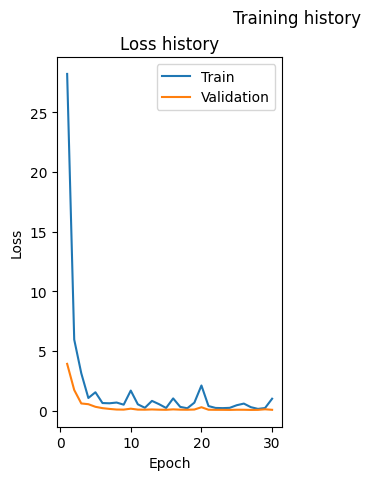

In [283]:
def print_history(history):
	absciss = np.arange(1, len(history["train"]["loss"])+1)
	plt.figure()
	plt.suptitle("Training history")
	plt.subplot(121)
	plt.title("Loss history")
	plt.plot(absciss, history["train"]["loss"], label="Train")
	plt.plot(absciss, history["val"]["loss"], label="Validation")
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.show()
print_history(history)

In [284]:
def predict(model, loader, model_name):
    preds = []
    ground_truth = []
    model.eval()
    df = pd.DataFrame()
    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X.to(mode["device"]))
            preds.append([tensor.item() for tensor in y_pred])
            ground_truth.append([tensor.item() for tensor in y])
    preds = [item for sublist in preds for item in sublist]
    ground_truth = [item for sublist in ground_truth for item in sublist]

    df["pred"] = preds
    df["ground_truth"] = ground_truth
    df.index = test.tail(len(y_test)).index

    mae = mae_sklearn(preds, ground_truth)
    mse = mse_sklearn(preds, ground_truth, squared=True)
    rmse = mse_sklearn(preds, ground_truth, squared=False)

    print(f"Performance measuers with unseen data on {model_name}")
    print("MAE: {:.2f}".format(mae), "MSE: {:.2f}".format(mse), "RMSE: {:.2f}".format(rmse))
    print()

    return df

In [285]:
model_1_history = predict(model_1, test_dataloader, "FCN")
model_2_history = predict(model_2, test_dataloader, "LSTM")
model_3_history = predict(model_3, test_dataloader, "LSTM Attention")

Performance measuers with unseen data on FCN
MAE: 0.90 MSE: 4.31 RMSE: 2.08

Performance measuers with unseen data on LSTM
MAE: 0.10 MSE: 0.09 RMSE: 0.30

Performance measuers with unseen data on LSTM Attention
MAE: 0.10 MSE: 0.10 RMSE: 0.31



In [286]:
import cufflinks as cf
from plotly.offline import init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

model_3_history.iplot()